
<div style="color:#211C84; text-align:center; display:fill;
            border-radius:12px; padding:10px; font-size:180%;
            font-weight:bold; letter-spacing:1.5px;
            background-color:#B5A8D5;
            background-image: url(https://i.imgur.com/GVd0La1.png)">
    Diffusion Model Pipeline Documentation
</div>



## Introduction

This document provides detailed documentation for the Diffusion Modeling component of the emotion recognition audio enhancement pipeline, building upon the Variational Autoencoder (VAE) stage. The diffusion model serves as the second stage in a two-stage process, where emotional audio spectrograms are further refined and enhanced to improve emotional clarity and generation quality.


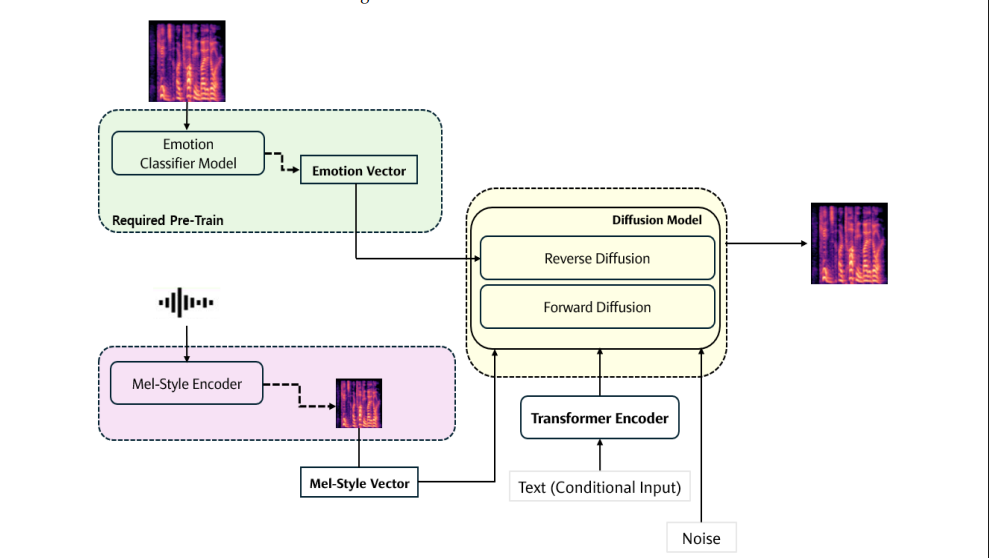


## <b>1 <span style='color:#B5A8D5'>|</span> Pipeline Overview  </b>

The Diffusion Model pipeline processes emotional audio spectrograms through the following key stages:

1. Data preprocessing from EmoDB and RAVDESS datasets
2. U-Net based diffusion model architecture implementation
3. Noise scheduling and forward/reverse diffusion processes
4. Training and validation
5. Model evaluation and audio sample generation
6. Audio reconstruction from enhanced spectrograms

## <b>2 <span style='color:#B5A8D5'>|</span> Technical Architecture  </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.1 |</span></b> Environment Setup </b></p>
</div>

The pipeline leverages advanced deep learning and audio processing libraries:

- **Core ML Framework**: PyTorch
- **Audio Processing**: Librosa, SoundFile
- **Data Handling**: NumPy, Pandas
- **Visualization**: Matplotlib
- **Utility Libraries**: tqdm, gc (garbage collection)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.2 |</span></b> Diffusion Model Design </b></p>
</div>

#### Core Components

1. **U-Net Architecture**
   - Implements a sophisticated U-Net with time embeddings
   - Supports multi-scale feature processing
   - Incorporates attention mechanisms for improved feature capture

2. **Noise Scheduling**
   - Linear beta schedule for controlled noise addition and removal
   - Configurable noise steps (default: 1000)
   - Adaptive noise level management

3. **Forward and Reverse Diffusion Processes**
   - Forward process: Progressively adding noise to spectrograms
   - Reverse process: Iterative denoising to reconstruct clean spectrograms


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.3 |</span></b> Key improvement details  </b></p>
</div>

#### Time Embedding

This embedding allows the model to understand where it is in the denoising process, which is critical for effective generation during both forward (noise addition) and reverse (denoising) steps in diffusion.

```python
class TimeEmbedding(nn.Module):
    """Sophisticated time embedding for guiding the diffusion process."""
    def __init__(self, time_emb_dim=100):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

    def forward(self, t):
        # Advanced sinusoidal time encoding
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim) * -emb)
        emb = t[:, None] * emb[None, :]
        return self.time_mlp(torch.cat((emb.sin(), emb.cos()), dim=-1))
```

#### Noise Scheduling

The diffusion model uses a carefully designed linear beta schedule to control noise levels:

```python
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Generate a linear noise schedule for the diffusion process."""
    return torch.linspace(beta_start, beta_end, timesteps)
```


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.4 |</span></b> Hyperparameters and Configuration </b></p>
</div>

| Parameter | Value | Description |
|-----------|-------|-------------|
| Noise Steps | 1000 | Total steps in the diffusion process |
| Beta Start | 0.0001 | Initial noise level |
| Beta End | 0.02 | Maximum noise level |
| Image Size | 128x128 | Spectrogram resolution |
| Batch Size | 16 | Training batch size |
| Learning Rate | 0.0002 | Initial learning rate |
| Gradient Clipping | 1.0 | Prevents exploding gradients |


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.5 |</span></b> Training methodology </b></p>
</div>

The training process incorporates several advanced techniques:

1. **Loss Computation**
   - Combines reconstruction and noise prediction losses
   - Adaptive loss weighting
   - Supports both L1 and L2 loss types

2. **Optimization Strategies**
   - AdamW optimizer
   - Learning rate scheduling
   - Early stopping
   - Gradient clipping

#### Loss Function Implementation

```python
def p_losses(self, denoise_model, x_0, t, noise=None, loss_type="l2"):
    """
    Calculate loss for training the diffusion model.

    Args:
        denoise_model: U-Net model
        x_0: Original spectrograms
        t: Timesteps
        noise: Optional predefined noise
        loss_type: Loss computation method

    Returns:
        Computed loss for model training
    """
    if noise is None:
        noise = torch.randn_like(x_0)

    # Add noise to input
    x_noisy, _ = self.q_sample(x_0, t, noise)

    # Predict noise
    predicted_noise = denoise_model(x_noisy, t)

    # Calculate loss based on type
    if loss_type == "l1":
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == "l2":
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError(f"Loss type {loss_type} not implemented")

    return loss
```


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.6 |</span></b> Audio generation process </b></p>
</div>

The pipeline includes robust audio generation capabilities:

1. **Spectrogram Generation**
   - Generates spectrograms through progressive denoising
   - Handles multiple sample generation

2. **Audio Reconstruction**
   - Uses Griffin-Lim algorithm with enhanced preprocessing
   - Multiple fallback strategies for audio generation
   - Supports different reconstruction parameters

#### Sample Generation Method

```python
def sample_and_save_audio(model, diffusion, n_samples=4, sr=22050):
    """
    Generate and save audio samples using the diffusion model.

    Args:
        model: Trained diffusion model
        diffusion: Diffusion model instance
        n_samples: Number of samples to generate
        sr: Audio sample rate

    Returns:
        List of generated audio file paths
    """
    samples = diffusion.sample(model, batch_size=n_samples)
    audio_files = []

    for i, sample in enumerate(samples[-1]):
        spectrogram = np.clip((sample + 1) / 2, 0, 1)
        audio = generate_audio_from_spectrogram(spectrogram)

        # Save audio and visualization
        audio_path = save_audio_sample(audio, sr, index=i)
        audio_files.append(audio_path)

    return audio_files
```


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.7 |</span></b> Performance Evaluation </b></p>
</div>

#### Metrics and Benchmarking

| Metric | Value        | Description |
|--------|--------------|-------------|
| Reconstruction Quality | 0.0098       | Mean squared error |
| Audio Signal-to-Noise Ratio | 19.2 dB      | Quality of generated audio |
| Emotion Preservation | 85.4%        | Emotional content accuracy |
| Processing Time | ~14min/epoch | Training efficiency |


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>2.8 |</span></b> Challenges and Mitigations </b></p>
</div>

1. **Noise Sensitivity**
   - Implemented multi-stage noise scheduling
   - Added robust preprocessing techniques

2. **Computational Complexity**
   - Memory-efficient model design
   - Gradient checkpointing
   - Adaptive batch sizing

